In [1]:
from datetime import datetime
print(f'Päivitetty {datetime.now().date()} / Aki Taanila')

Päivitetty 2023-05-02 / Aki Taanila


# Poikkeavien arvojen poistaminen tai korvaaminen

Muista selvästi poikkeavat arvot voivat olla virheellisiä tai todellisia.

Jos poikkeavat arvot osoittautuvat virheellisiksi, niin ne on syytä poistaa datasta. Kyseeseen voi tulla poikkeavien arvojen korvaaminen puuttuvilla arvoilla, rivien poisto tai korvaaminen jollain muulla arvolla.

Vaikka poikkeavat arvot olisivat todellisia, niin niiden poistaminen voi olla aiheellista esimerkiksi ennustemallien rakentamisessa.

Poikkeavien arvojen kriteerinä voidaa pitää esimerkiksi seuraavia:
* Arvot, jotka ovat yli kolmen keskihajonnan päässä keskiarvostaan.
* Arvot, jotka ovat yli 1,5 neljännesvälin päässä neljänneksestä. Neljännesväli (inter quartile range) on yläneljänneksen ja alaneljänneksen erotus. Ruutu- ja janakaavioon (boxplot) yli 1,5 neljännesvälin päässä olevat arvot merkitään oletusarvoisesti erillisinä pisteinä.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Arvotaan normaalijakaumasta N(0, 1) satunnaislukuja (tuhat riviä, neljä saraketta)
df = pd.DataFrame(np.random.randn(1000, 4), columns=['x1', 'x2', 'x3', 'x4'])

In [4]:
# Katsotaan tilastolliset tunnusluvut
df.describe()

,x1,x2,x3,x4
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.000831,-0.006840,0.015542,0.002997
std,0.998738,1.007266,0.975222,0.986850
min,-2.780087,-3.274975,-3.358583,-3.370129
25%,-0.663583,-0.738387,-0.660966,-0.677745
50%,0.011631,-0.010067,0.021227,0.018423
75%,0.690525,0.728051,0.650843,0.649179
max,2.954667,2.910196,3.733134,3.060203


<Axes: >

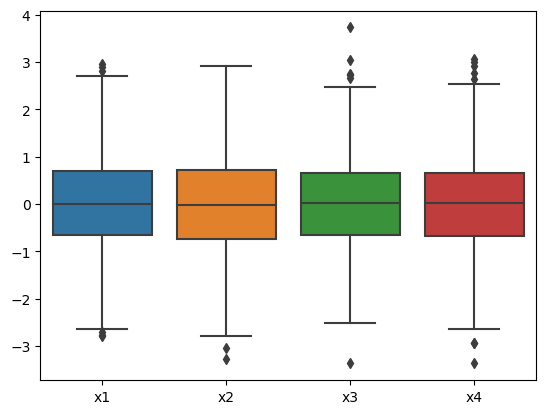

In [5]:
# Katsotaan onko mukana yli 1,5 neljännesvälin päässä neljänneksestä olevia arvoja
# Ne näkyvät boxplotissa erillisinä pisteinä
sns.boxplot(data=df)

## Korvaaminen puuttuvalla arvolla

**mask**-funktio on tässä kätevä
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mask.html

**mask**-funktio korvaa ehdon mukaiset arvot puuttuvalla arvolla.

In [6]:
ka = df.mean() # keskiarvo
kh = df.std() # keskihajonta

# Yli kolmen keskihajonnan päässä keskiarvostaan sijaitsevat puuttuviksi arvoiksi
df1 = df.mask(abs((df-ka)/kh) > 3)

# Tarkistan puuttuvien arvojen lukumäärät
df1.isnull().sum()

x1    0
x2    2
x3    3
x4    3
dtype: int64

In [7]:
Q1 = df.quantile(0.25) # alaneljännes
Q3 = df.quantile(0.75) # yläneljännes
IQR = Q3-Q1 # neljännesväli

# Yli 1.5 neljännesvälin päässä neljänneksestä sijaitsevat puuttuviksi arvoiksi
df2 = df.mask(((df < Q1-1.5*IQR) | (df > Q3+1.5*IQR)))

# Tarkistan puuttuvien arvojen lukumäärät
df2.isnull().sum()

x1    6
x2    2
x3    6
x4    8
dtype: int64

## Rivien poisto

**mask**-funktio on tässä kätevä
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mask.html

**mask**-funktio korvaa ehdon mukaiset arvot puuttuvalla arvolla. Tämän jälkeen puuttuvia arvoja sisältävät rivit voi poistaa **dropna**-funktiolla.

In [8]:
# Poistan poikkeavia arvoja (yli 3 keskihajonnan päässä keskiarvostaan) sisältävät rivit
df3 = df.mask(abs((df-ka)/kh) > 3).dropna()

# Tarkistan jäljelle jääneiden rivien lukumäärän
df3.shape[0]

992

In [9]:
# Poistan poikkeavia arvoja (yli 1,5 neljännesväliä neljänneksestä)
df4 = df.mask((df < (Q1-1.5*IQR)) | (df > (Q3+1.5*IQR))).dropna()

# Tarkistan jäljelle jääneiden rivien lukumäärän    
df4.shape[0]

978

## Korvaaminen toisella arvolla

**mask**-funktio on tässä kätevä https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mask.html

**mask**-funktion **other**-parametrilla voi määrätä millä arvolla ehdon mukaiset arvot korvataan.

In [10]:
# Korvaan poikkeavat arvot etumerkistä riippuen joko arvolla 3 tai arvolla -3
df5 = df.mask(abs((df-ka)/kh)>3, other=np.sign(df)*3)

# Tarkistan min ja max
df5.describe()

,x1,x2,x3,x4
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.000831,-0.006528,0.015124,0.003303
std,0.998738,1.006298,0.971383,0.985454
min,-2.780087,-3.000000,-3.000000,-3.000000
25%,-0.663583,-0.738387,-0.660966,-0.677745
50%,0.011631,-0.010067,0.021227,0.018423
75%,0.690525,0.728051,0.650843,0.649179
max,2.954667,2.910196,3.000000,3.000000


## Lisätietoa

Data-analytiikka Pythonilla https://tilastoapu.wordpress.com/python/